In [1]:
import requests
from io import BytesIO
from PIL import Image
import torch
from diffusers import DDIMScheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionImg2ImgPipeline

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.10/dist-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
# Use the DDIMScheduler scheduler here instead
scheduler = DDIMScheduler.from_pretrained("stabilityai/stable-diffusion-2-1",
                                            subfolder="scheduler")

In [3]:
!pip install onnx_graphsurgeon --extra-index-url https://pypi.ngc.nvidia.com

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip


In [4]:
!pip install onnxruntime onnxruntime-gpu colored


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip


In [5]:
!pip install polygraphy==v0.47.1 --extra-index-url https://pypi.ngc.nvidia.com

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip


In [6]:
import diffusers
print(f"polygraphy version: {diffusers.__version__}")

polygraphy version: 0.26.3


In [7]:
pipe = StableDiffusionImg2ImgPipeline.from_pretrained("stabilityai/stable-diffusion-2-1",
                                                custom_pipeline="stable_diffusion_tensorrt_img2img",
                                                revision='fp16',
                                                torch_dtype=torch.float16,
                                                scheduler=scheduler,)

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/pipeline_utils.py:270: FutureWarning: You are loading the variant fp16 from stabilityai/stable-diffusion-2-1 via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:655: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(
vae/diffusion_pytorch_model.safetensors not found
Loading pipeline components...: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.70it/s]


In [8]:
# re-use cached folder to save ONNX models and TensorRT Engines
pipe.set_cached_folder("stabilityai/stable-diffusion-2-1", revision='fp16',)

Fetching 16 files: 100%|████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 162491.20it/s]


In [9]:
pipe = pipe.to("cuda")

Running inference on device: cuda:0
Loading TensorRT engine: /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1/snapshots/f7f33030acc57428be85fbec092c37a78231d75a/engine/clip.plan


[I] Loading bytes from /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1/snapshots/f7f33030acc57428be85fbec092c37a78231d75a/engine/clip.plan


Loading TensorRT engine: /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1/snapshots/f7f33030acc57428be85fbec092c37a78231d75a/engine/unet.plan


[I] Loading bytes from /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1/snapshots/f7f33030acc57428be85fbec092c37a78231d75a/engine/unet.plan


Loading TensorRT engine: /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1/snapshots/f7f33030acc57428be85fbec092c37a78231d75a/engine/vae.plan


[I] Loading bytes from /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1/snapshots/f7f33030acc57428be85fbec092c37a78231d75a/engine/vae.plan


Loading TensorRT engine: /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1/snapshots/f7f33030acc57428be85fbec092c37a78231d75a/engine/vae_encoder.plan


[I] Loading bytes from /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1/snapshots/f7f33030acc57428be85fbec092c37a78231d75a/engine/vae_encoder.plan


In [10]:
url = "https://pajoca.com/wp-content/uploads/2022/09/tekito-yamakawa-1.png"
response = requests.get(url)
input_image = Image.open(BytesIO(response.content)).convert("RGB")

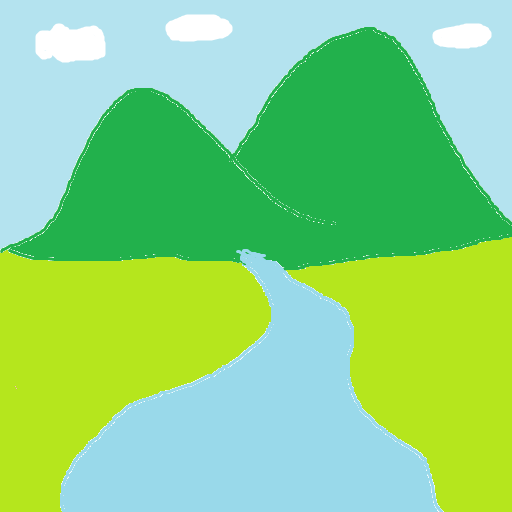

In [11]:
input_image

In [60]:
prompt = "a beautiful photo relaistic landscape, green mountains in the background, a river in the center, blue sky and some clouds"
negative_prompt = "cartoon, 3d, sketch, text, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, mutilated, mutation, deformed, blurry, dehydrated"
image = pipe(prompt, image=input_image, strength=0.85, num_inference_steps=60, guidance_scale=8.5,).images[0]
image.save('tensorrt_img2img_new_zealand_hills.jpg')

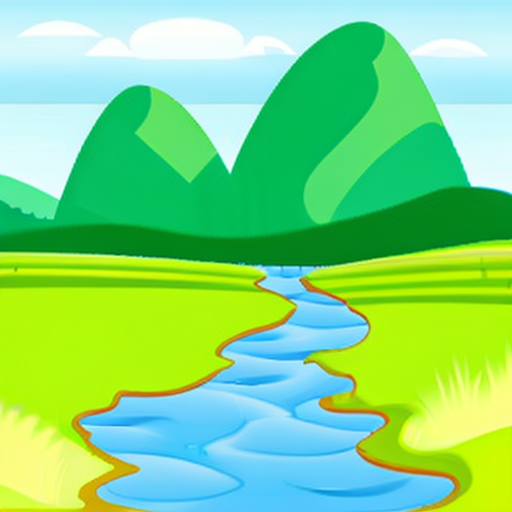

In [61]:
image

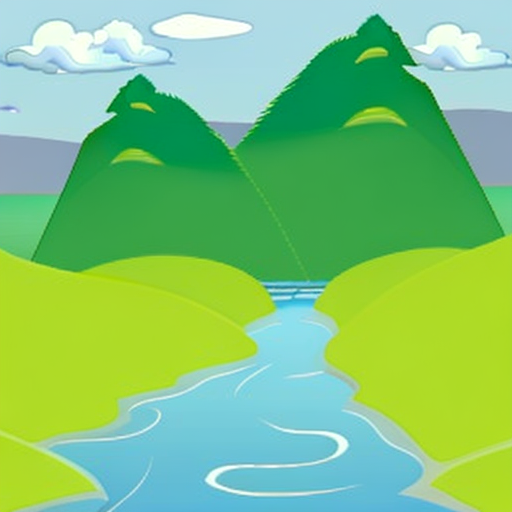

In [41]:
image

In [64]:
prompt = "photo relaistic landscape, new zealand hills"
negative_prompt = "cartoon, 3d, sketch, text, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, mutilated, mutation, deformed, blurry, dehydrated"
image = pipe(prompt, image=input_image, strength=0.85, num_inference_steps=60, guidance_scale=8.5,).images[0]
image.save('tensorrt_img2img_new_zealand_hills.jpg')

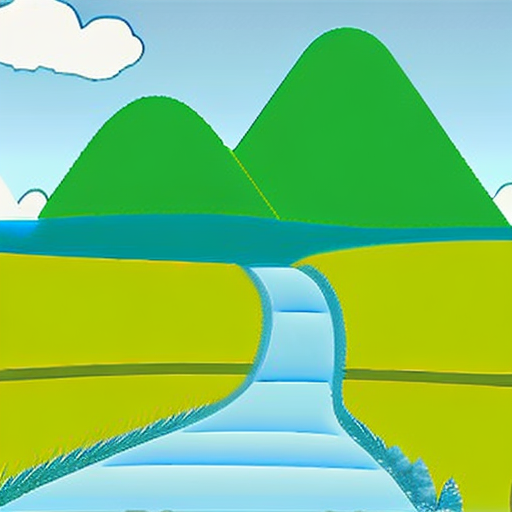

In [65]:
image

In [39]:
new_img = image.resize((200,200))
new_img.save("car_resized.jpg", "JPEG", optimize=True)

In [41]:
import tensorrt
print(f"TensorRT version: {tensorrt.__version__}")

TensorRT version: 8.6.1


In [879]:
prompt = "Ultrarealistic photo of a beautiful landscape, two green hills in the background, a river in the center, blue sky with some clouds, canon eos 5d mark iv"
negative_prompt = "fake, blurry, graphic, graffiti, 3d, cartoon, sketch, worst quality, low quality, graphics"
image = pipe(prompt, image=input_image, strength=0.75, guidance_scale=7.5,negative_prompt=negative_prompt).images[0]
image.save('output2.JPEG')

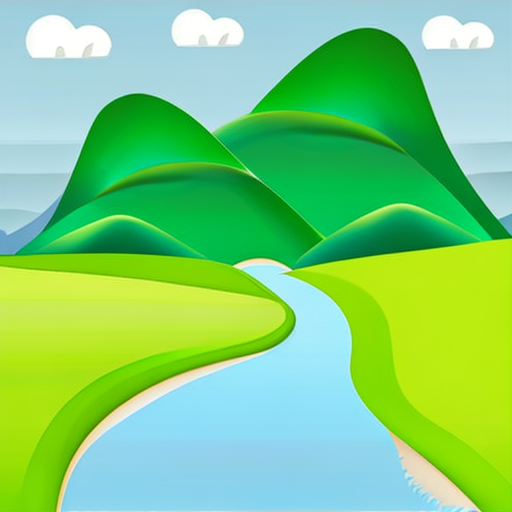

In [880]:
image

In [471]:
prompt = "Ultrarealistic photo of a beautiful landscape, green hills in the background, a river in the center and blue sky with some clouds, canon eos 5d mark iv"
negative_prompt = "fake, blurry, cartoon, 3d, sketch, text, worst quality, low quality"
image = pipe(prompt, image=input_image, strength=0.95, guidance_scale=8,).images[0]
image.save('tensorrt_img2img_new_zealand_hills2.JPEG')

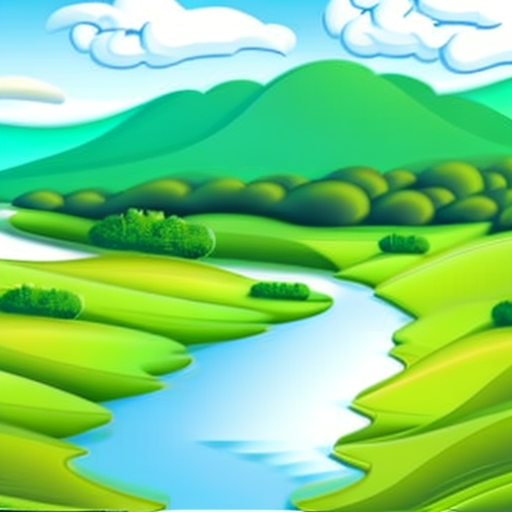

In [286]:
image

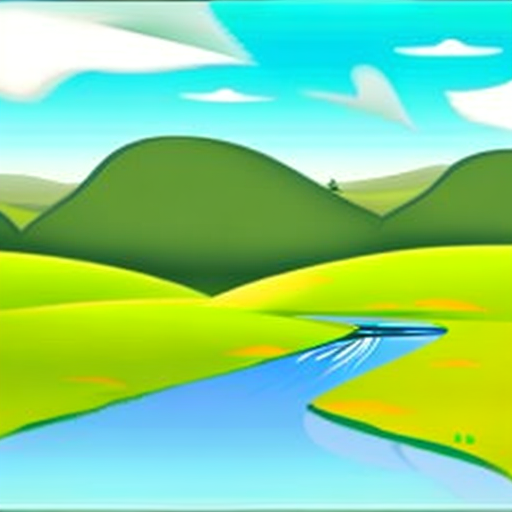

In [472]:
image

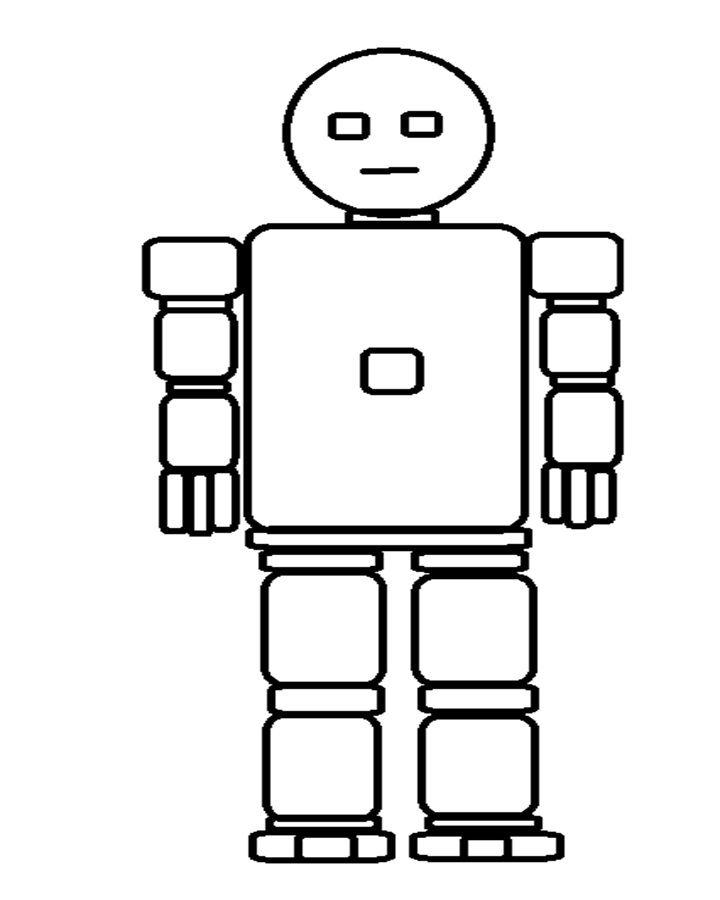

In [881]:
input_image = Image.open("Robot.jpg")
input_image

In [915]:
prompt = "photo relaistic humanoid robot"
negative_prompt = "cartoon, 3d, sketch, text, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, mutilated, mutation, deformed, blurry, dehydrated"
image = pipe(prompt, image=input_image, strength=0.75, guidance_scale=35,).images[0]
image.save('humanoid.jpg')

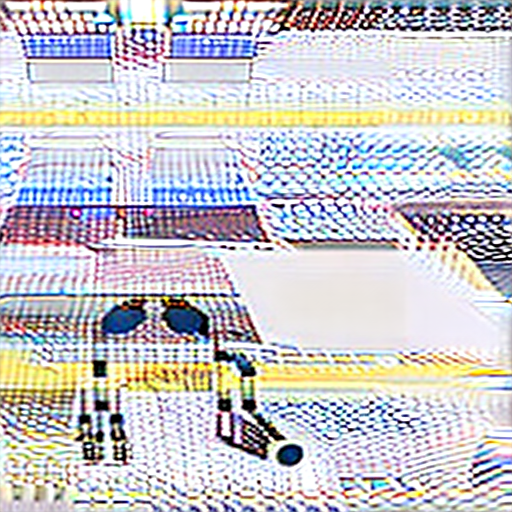

In [916]:
image